<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

##Reference:
###1. Stackoverflow
###2. Applied AI Course

<h1> Business Problem </h1>

__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2>Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1> Machine Learning Probelm </h1>

<h2>  Data </h2>

<h3> Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2>  Mapping the real world problem to an ML problem </h2>

<h3> Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h2> Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1> Exploratory Data Analysis </h1>

In [1]:
# import the libraries as shown below

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import time
import warnings
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
from tqdm import tqdm
# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import datetime as dt
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<h2>  Reading data and basic stats </h2>

In [ ]:
df = pd.read_csv("train.txt")

print("Number of data points:",df.shape[0])

Number of data points: 17


In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            17 non-null     int64 
 1   qid1          17 non-null     int64 
 2   qid2          17 non-null     int64 
 3   question1     16 non-null     object
 4   question2     16 non-null     object
 5   is_duplicate  17 non-null     int64 
dtypes: int64(4), object(2)
memory usage: 944.0+ bytes


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

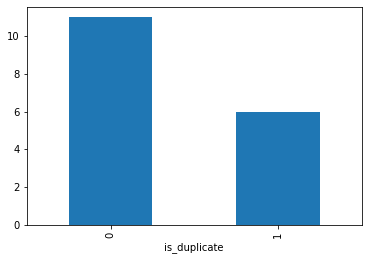

In [ ]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [ ]:
print('Total number of question pairs for training:{}'.format(len(df)))

Total number of question pairs for training:17


In [ ]:
print('Question pairs are not Similar (is_duplicate = 0):{}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('Question pairs are Similar (is_duplicate = 1):{}%'.format(round(df['is_duplicate'].mean()*100, 2)))

Question pairs are not Similar (is_duplicate = 0):64.71000000000001%
Question pairs are Similar (is_duplicate = 1):35.29%


<h3> Number of unique questions </h3>

In [ ]:
ques_ids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_ques = len(np.unique(ques_ids))
ques_morethan_onetime = np.sum(ques_ids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}'.format(unique_ques))

print ('Number of unique questions that appear more than one time: {} ({}%)'.format(ques_morethan_onetime,ques_morethan_onetime/unique_ques*100))

print ('Max number of times a single question is repeated: {}'.format(max(ques_ids.value_counts()))) 

q_vals=ques_ids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 34
Number of unique questions that appear more than one time: 0 (0.0%)
Max number of times a single question is repeated: 1


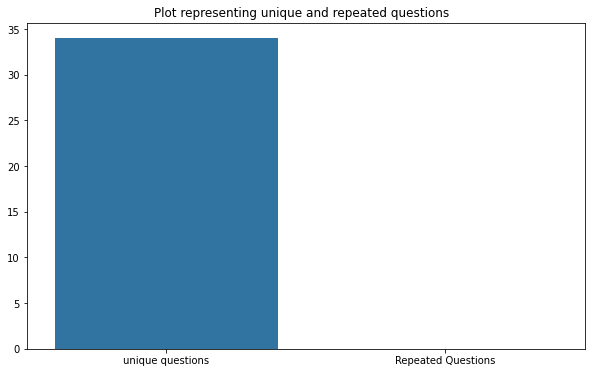

In [ ]:

x = ["unique questions" , "Repeated Questions"]
y =  [unique_ques , ques_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3> Checking for Duplicates </h3>

In [ ]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",df.shape[0] - (pair_duplicates).shape[0])

Number of duplicate questions 0


<h3> Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 1


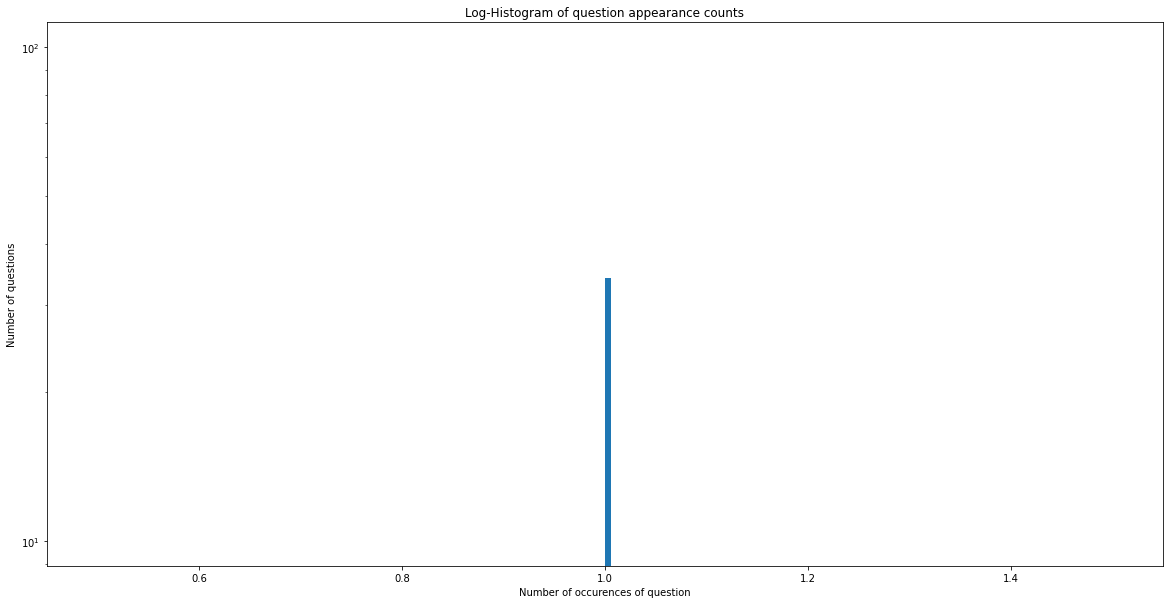

In [ ]:
plt.figure(figsize=(20, 10))

plt.hist(ques_ids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}'.format(max(ques_ids.value_counts()))) 

<h3> Checking for NULL values </h3>

In [ ]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
nan_rows

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2


- There are three rows with null values in question2 

In [ ]:
# Filling the null values with ' '
df = df.dropna() 


<h2>Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [ ]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,1,1,76,39,13,7,2.0,20.0,0.100000,2,0


<h3> Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [ ]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  4
Minimum length of the questions in question2 :  6
Number of Questions with minimum length [question1] : 0
Number of Questions with minimum length [question2] : 0


<h4>Feature: word_share </h4>

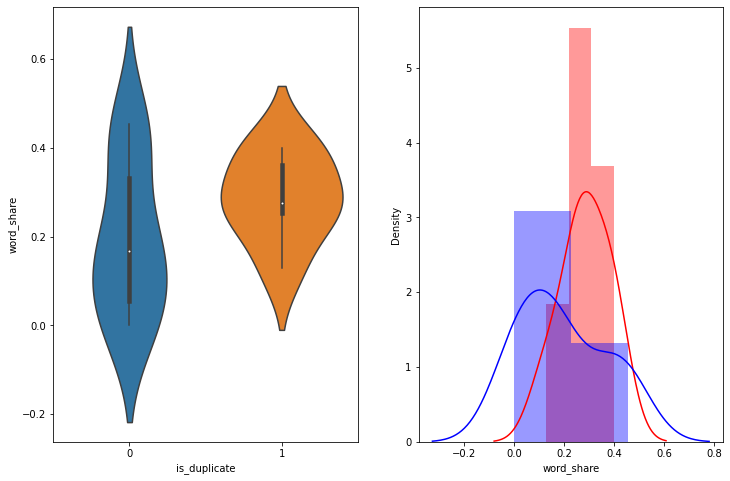

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> Feature: word_Common </h4>

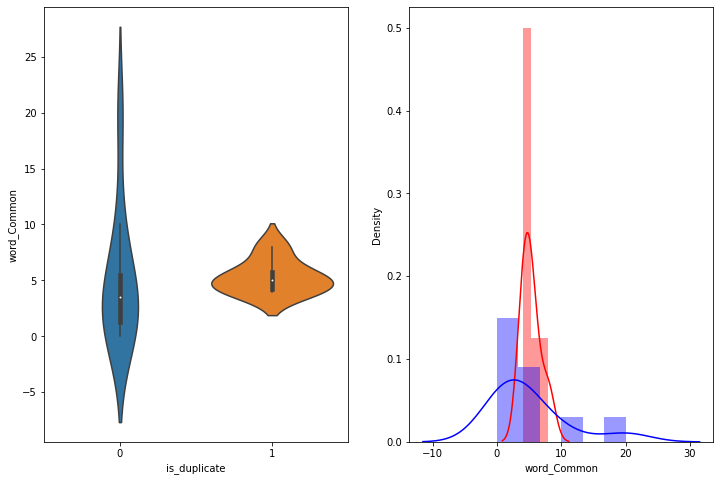

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

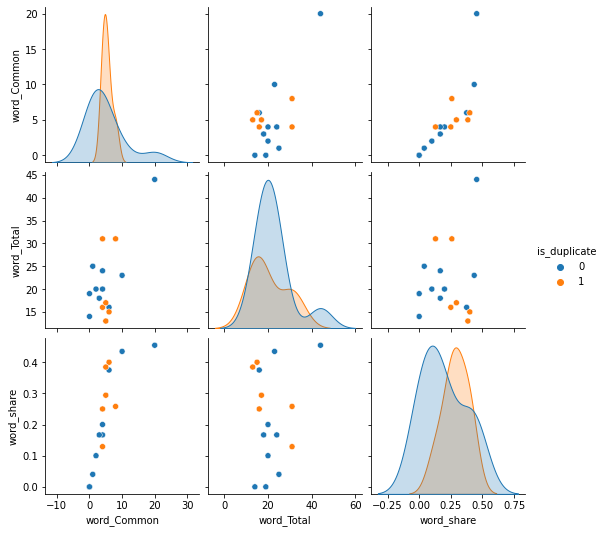

In [ ]:
n = df.shape[0]
sns.pairplot(df[['word_Common', 'word_Total', 'word_share', 'is_duplicate']][0:n], hue='is_duplicate', vars=['word_Common', 'word_Total', 'word_share'])
plt.show()

In [ ]:
df_duplicate = df[df['is_duplicate'] == 1]
df_nonduplicate = df[df['is_duplicate'] == 0]

print ("Number of data points in class 1 (duplicate pairs) :",len(df_duplicate))
print ("Number of data points in class 0 (non duplicate pairs) :",len(df_nonduplicate))


Number of data points in class 1 (duplicate pairs) : 6
Number of data points in class 0 (non duplicate pairs) : 10


<h2>Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [ ]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

<h2> Featurizing text data with tfidf weighted word-vectors </h2>

In [ ]:
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,1,1,76,39,13,7,2.0,20.0,0.100000,2,0


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [ ]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)


100%|██████████| 16/16 [00:00<00:00, 94.84it/s]


In [ ]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|██████████| 16/16 [00:00<00:00, 93.42it/s]


In [ ]:
df_q1 = pd.DataFrame(df.q1_feats_m.values.tolist(), index= df.index)
df_q2 = pd.DataFrame(df.q2_feats_m.values.tolist(), index= df.index)

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,q1_feats_m,q2_feats_m
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,"[-3.8901073932647705, 20.304443657398224, -35....","[-12.331659734249115, 32.19257801771164, -31.1..."
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0,"[0.6123348474502563, -18.134884983301163, -14....","[12.865045869257301, -0.3618507385253906, -48...."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,"[52.94309484958649, 11.470338620245457, -3.265...","[78.32479038089514, 37.50541251897812, -0.6927..."
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,"[33.65871334075928, -14.111445724964142, 0.836...","[15.163574859499931, 25.522109523415565, 20.25..."
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,1,1,76,39,13,7,2.0,20.0,0.100000,2,0,"[26.93554499745369, -13.713625252246857, -21.3...","[-4.346223831176758, -6.020967781543732, -29.9..."


In [ ]:
# Questions 1 tfidf weighted word2vec
df_q1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0,-3.890107,20.304444,-35.584164,4.276663,74.896054,61.099366,28.552881,28.235536,32.595708,124.358917,20.353079,-9.250395,-1.306328,-36.252351,-3.611569,-45.392524,-26.898797,-29.093627,-26.695414,2.253143,30.468831,33.721527,5.834834,11.861404,-28.668763,-11.589463,18.474469,2.073863,37.821950,-53.153247,62.993943,-27.222731,5.600689,-41.756653,-24.380586,-37.970217,86.252546,-22.821122,-16.558682,-35.907082,...,50.677418,27.638519,-26.335065,44.730118,48.413266,-25.739801,48.405106,22.813933,-9.479971,-47.479084,34.150586,-48.544100,-17.941904,25.823509,-65.704552,5.889124,-5.261914,-21.261524,-31.220942,22.707537,62.365847,-62.370815,12.103319,3.965498,5.018870,-41.031326,-20.048632,-9.033819,15.532590,-11.559832,-31.678437,-16.836430,-0.421258,63.636762,-54.986165,-39.316432,-38.092721,54.602324,25.220160,-9.142389
1,0.612335,-18.134885,-14.002938,14.261087,76.451584,31.379424,37.717019,13.786195,37.975428,47.374707,23.082093,-11.393444,-5.304889,-12.814711,-36.216892,-37.489102,5.744476,13.255750,-4.344752,-20.803270,8.772268,-9.874158,-5.743981,-21.343202,-38.439503,-22.444162,1.733546,-39.353638,15.780406,-45.892454,-5.650289,9.368152,3.084818,-12.938267,21.018510,-37.965347,60.301374,-21.877022,-37.001342,-16.753889,...,22.188100,38.026017,2.608275,-20.728983,-26.141548,-12.822930,12.647771,13.758892,23.864861,26.300385,26.693592,-21.867264,-16.196680,26.387212,-42.330284,-3.056694,21.914230,-4.316699,-9.873287,-11.967894,52.734521,-15.741061,-18.028919,-20.142799,33.690378,-27.989318,-1.972000,8.813562,-3.665562,31.531585,-20.503914,-12.590355,7.423956,12.563918,-44.678857,22.305072,11.156884,50.378927,39.849143,8.609022
2,52.943095,11.470339,-3.265820,-1.489804,38.531875,8.535446,3.775488,28.182203,53.511482,124.122493,-12.055783,-32.163934,-34.232564,-53.445768,21.955639,8.649957,-17.537504,-8.685748,-13.071865,-30.580681,29.486677,63.143336,-1.411218,-23.431091,-26.208651,19.848325,-35.062611,-41.887616,22.057683,-29.123204,43.076456,59.393385,-8.458217,-21.299002,-26.806787,-7.326773,20.918338,-39.155005,-75.427817,-36.838555,...,72.058284,20.494430,5.844455,11.622522,72.050020,-72.058103,-30.660746,73.274524,-1.768635,-8.842135,18.606375,-51.526086,-4.516459,40.299666,-5.485763,5.481775,35.611879,7.069308,-20.683479,-4.944572,60.767626,-65.059671,-11.954851,-10.384092,6.489030,12.776017,-29.823596,38.884628,34.639847,-50.268013,-43.051180,60.184135,13.470498,27.989983,-30.701956,-29.359833,-33.415620,43.001259,56.456515,-22.323801
3,33.658713,-14.111446,0.836994,-45.687915,9.618204,-14.352659,39.882005,69.322843,19.338700,35.442755,-56.724156,-0.589013,73.396357,47.689834,35.307024,68.220561,-29.846330,-44.232566,-29.419426,8.998124,-23.091029,-2.865553,-19.445971,-28.911958,8.199001,68.445273,4.625885,-67.841691,-14.440730,-0.861857,-24.542095,-6.067030,22.361706,-8.122326,1.961340,-21.325310,11.195079,-49.996515,-34.138630,1.239559,...,70.759702,12.975360,-14.716538,1.678675,16.181865,-94.002659,-24.243046,8.008126,-8.960708,-15.889009,-57.157163,-2.444449,35.381614,12.914194,-21.448546,5.804887,31.060361,13.881139,-5.960832,-64.975911,70.063483,-28.064594,-32.106498,37.931101,23.006551,-24.001708,-25.050339,32.511440,-0.756591,-10.402809,11.464213,27.107195,-1.036201,4.775734,-35.680407,-4.422104,-40.160752,44.936297,-11.266835,36.456198
4,26.935545,-13.713625,-21.382149,-27.669272,38.189761,-17.876178,24.866073,37.555594,57.902809,124.357407,13.227327,26.823877,59.873512,-37.979112,8.281935,18.342303,-30.975476,-14.526912,-25.455414,-16.225441,45.521023,14.057025,-23.748321,-11.768589,-40.885379,6.434516,-24.728182,-58.970782,57.152902,-30.044526,40.854263,39.887034,12.388897,-18.808324,-8.927560,-34.841355,15.898392,-62.390364,-15.708442,-31.810608,...,61.440321,12.969900,-10.

In [ ]:
# Questions 2 tfidf weighted word2vec
df_q2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0,-12.331660,32.192578,-31.153167,-0.486428,57.151714,42.124120,22.541498,33.416076,7.931422,108.722070,-4.097496,-1.598951,0.142534,-31.278082,0.766731,-28.952160,-25.143676,-22.495549,-21.532490,4.461212,31.739038,30.812848,-2.431602,15.893303,-22.899309,-5.338850,28.794901,-1.064032,40.835731,-43.498933,55.891635,-3.400161,20.354402,-39.569644,-15.978675,-25.530412,74.116683,-27.974964,-8.332891,-29.186993,...,55.667332,11.798653,-23.653717,49.475913,48.005463,-29.783317,45.158508,21.158004,-11.105656,-47.236019,31.261590,-30.492361,-20.642893,19.341431,-54.716761,4.422640,4.329219,-14.495586,-32.771184,26.814773,57.940923,-54.801496,17.155609,8.584735,15.930280,-41.871671,-23.571233,3.239389,-20.985686,-28.390445,-35.342502,-4.503024,-7.153258,56.099373,-37.615219,-26.476134,-41.245493,47.635584,20.500035,-9.600599
1,12.865046,-0.361851,-48.085174,-12.361250,43.975465,-6.747856,48.968813,27.428932,54.827077,112.574017,1.370006,-10.727128,41.384185,-43.602130,-3.940308,-48.166162,8.275060,37.976107,-7.782691,-48.825992,-42.978205,12.155098,-16.549752,-24.237549,-63.650272,6.937010,17.490507,-46.859065,28.580918,-84.779590,47.713110,32.104825,-25.992235,-33.839873,14.873424,-79.788897,80.310843,-42.119437,-55.653958,-35.869491,...,91.048975,42.399712,-44.496885,-31.599129,-7.608633,-49.486689,15.555595,22.939917,12.498977,0.165254,30.251498,-10.769565,-19.452174,49.679164,-36.519640,31.395389,-1.321160,-6.424360,-29.365982,-0.309196,91.808578,-48.238002,-20.344377,3.638722,7.950152,-85.554269,-6.587907,31.377154,8.760873,-36.824891,9.266038,-9.578270,6.102523,21.963044,4.394703,56.609576,-32.038109,93.085985,36.613139,33.741564
2,78.324790,37.505413,-0.692790,8.451272,59.825852,49.000279,48.277140,20.382644,12.196986,85.051319,-49.824410,-14.633128,-28.367897,-50.391695,-7.629652,23.758193,10.597156,-2.361127,-5.850795,-14.037072,-8.342119,14.317191,-27.524530,-1.358347,-1.904920,22.492743,-16.352099,-7.598703,15.005600,-47.466245,60.750514,3.013929,17.337835,-23.161163,16.147146,-32.754776,45.157277,-32.229696,-57.692594,-6.849994,...,13.083034,-39.022064,17.591164,21.745160,62.965273,-48.195898,-6.252562,18.820576,-34.189207,-63.331380,5.714883,-32.615333,-25.060835,46.600347,5.700053,-4.486481,19.841844,-15.618965,10.075975,1.557965,76.560091,-43.019879,-13.106893,-11.978392,-0.607237,2.299991,-25.568662,24.224181,19.977924,-32.828306,-7.310355,-1.144022,46.365135,18.404990,-43.058625,-86.659072,-50.848553,8.996112,8.212813,14.198789
3,15.163575,25.522110,20.252827,-3.985652,24.710421,26.561146,20.096185,14.516984,1.503444,58.058274,-43.182072,-27.282775,-25.118142,-15.336253,-8.042924,4.833689,-33.317441,-12.474591,-8.297561,2.508788,22.130234,-21.147471,-13.225250,-1.567492,-22.838256,22.490597,-15.986093,-24.267462,10.748238,5.597456,-2.369658,34.901382,5.663395,-1.115345,-22.891081,2.323979,24.378639,-24.095533,-47.102635,-22.932194,...,17.358560,16.655250,4.752090,9.568971,20.380989,-38.898088,14.726570,-23.601381,-35.833416,-7.321320,17.097357,3.770694,11.036578,27.776525,10.991627,31.606386,30.001807,-18.656978,19.617903,-2.984820,26.730247,-26.439931,-7.776667,-12.967753,-24.221207,-14.701681,6.940082,36.002397,-14.174709,-32.868220,-7.199477,27.570449,27.295655,19.702725,11.785244,-23.742978,-2.947103,-17.340645,-0.966707,8.472075
4,-4.346224,-6.020968,-29.964214,-33.606428,18.092039,-31.288104,23.400398,42.908922,8.295971,28.432812,-22.014694,3.470299,42.693771,-23.371104,11.112865,12.081229,6.656588,-24.230129,-20.966290,23.316242,2.422574,20.638503,-7.663628,-3.826217,-21.143178,8.414028,17.295070,-14.615360,23.031948,-23.343913,30.122885,14.706272,12.905235,-21.816705,-1.195218,-34.765760,-7.680676,-11.097719,-0.954956,-12.481402,...,29.131792,9.856003,-23.068757,75.608846,39.48

In [ ]:
df = df.drop("q1_feats_m", axis=1)
df = df.drop("q2_feats_m", axis=1)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,1,1,76,39,13,7,2.0,20.0,0.100000,2,0


In [ ]:
# storing the final features to csv file
if not os.path.isfile('final_features.csv'):
    df_q1['id']=df['id']
    df_q2['id']=df['id']
    df  = df.merge(df_q1, on='id',how='left')
    df  = df.merge(df_q2, on='id',how='left')
    df.to_csv('final_features.csv')

<h1>Machine Learning Models </h1>

In [ ]:
y_true = df["is_duplicate"].copy()
df.drop(['id', 'qid2','qid1','question1','question2','is_duplicate'], axis=1, inplace=True)

In [ ]:
y_true.count()

16

<h2>Random train test split( 70:30) </h2>

In [ ]:
X_train,X_test, Y_train, Y_test = train_test_split(df,y_true,test_size=0.3,random_state=42)

In [ ]:
print(f"Rows in train set(X): {len(X_train)}\nRows in test set(X): {len(X_test)}\n")
print(f"Rows in train set(Y): {len(Y_train)}\nRows in test set(Y): {len(Y_test)}\n")

Rows in train set(X): 11
Rows in test set(X): 5

Rows in train set(Y): 11
Rows in test set(Y): 5



<h2> Building a random model (Finding worst-case log-loss) </h2>

In [ ]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(Y_train)
train_len = len(Y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(Y_test)
test_len = len(Y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6363636363636364 Class 1:  0.36363636363636365
---------- Distribution of output variable in test data ----------
Class 0:  0.4 Class 1:  0.4


In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

##Random Model

Log loss on Test Data using Random Model 0.9916017813365009


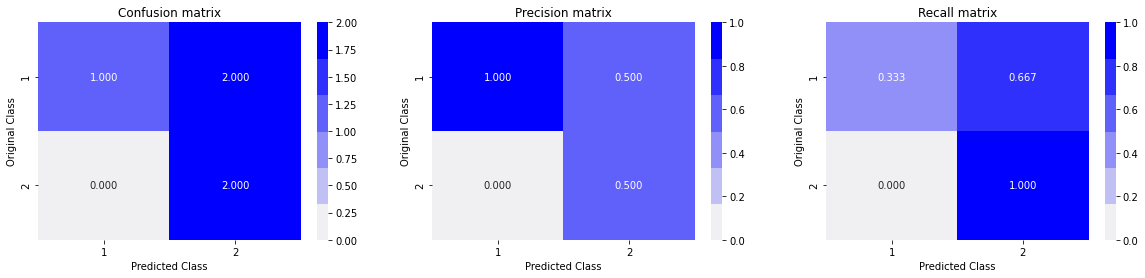

In [ ]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(Y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(Y_test, predicted_y)

<h2>Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.6748593790099362
For values of alpha =  0.0001 The log loss is: 0.7006002361706688
For values of alpha =  0.001 The log loss is: 0.7006002361721287
For values of alpha =  0.01 The log loss is: 0.673813804932397
For values of alpha =  0.1 The log loss is: 0.6770934906421628
For values of alpha =  1 The log loss is: 0.6648634671869136
For values of alpha =  10 The log loss is: 0.6861251170358026


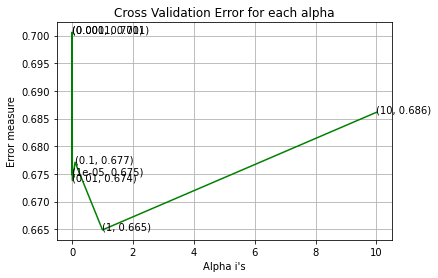

For values of best alpha =  1 The train log loss is: 0.6919999309100764
For values of best alpha =  1 The test log loss is: 0.6648634671869136
Total number of data points : 5


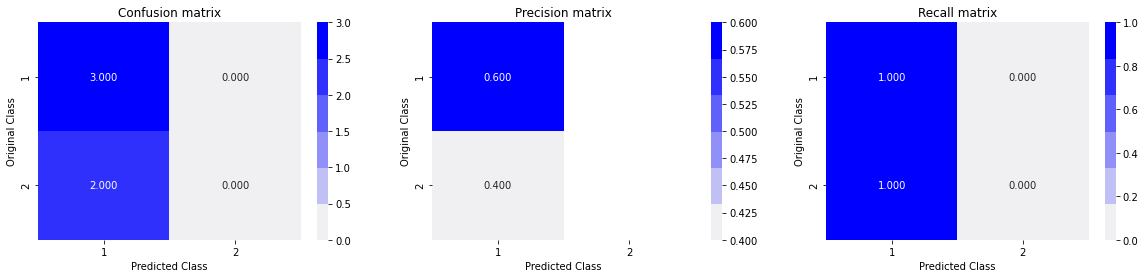

In [ ]:
from sklearn.linear_model import SGDClassifier
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, Y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, Y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)

<h2> Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.6748593790099362
For values of alpha =  0.0001 The log loss is: 0.6748593790099362
For values of alpha =  0.001 The log loss is: 0.6874470851758365
For values of alpha =  0.01 The log loss is: 0.6537924347102788
For values of alpha =  0.1 The log loss is: 0.6819465556667915
For values of alpha =  1 The log loss is: 0.6984083545346313
For values of alpha =  10 The log loss is: 0.6582449077079524


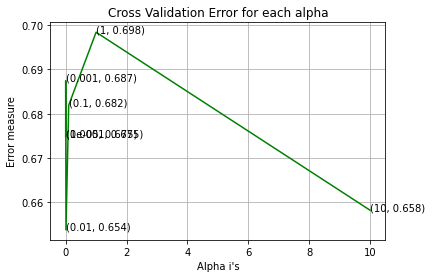

For values of best alpha =  0.01 The train log loss is: 0.6879130261695198
For values of best alpha =  0.01 The test log loss is: 0.6537924347102788
Total number of data points : 5


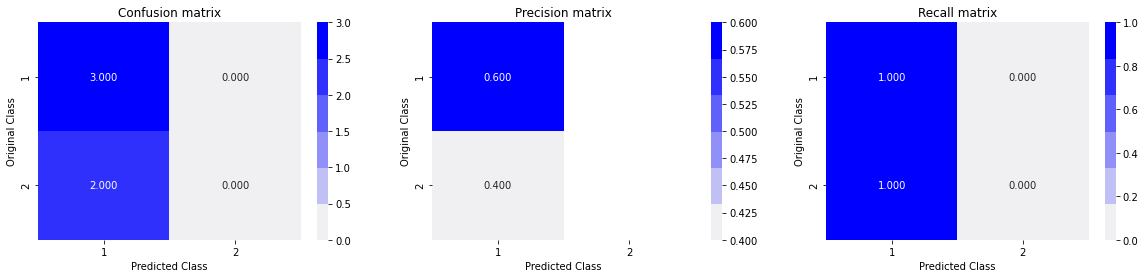

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, Y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, Y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)

<h2>XGBoost </h2>

In [ ]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=Y_train)
d_test = xgb.DMatrix(X_test, label=Y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,Y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.687402	valid-logloss:0.693955
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.636437	valid-logloss:0.7023
[20]	train-logloss:0.595283	valid-logloss:0.710882
Stopping. Best iteration:
[0]	train-logloss:0.687402	valid-logloss:0.693955

The test log loss is: 0.7108822703361511


Total number of data points : 5


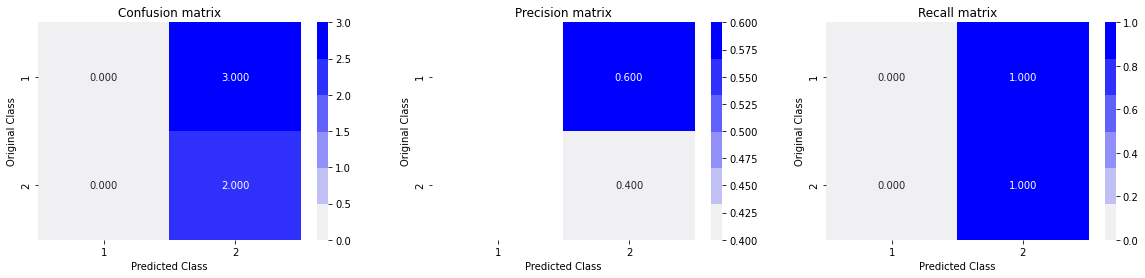

In [ ]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)